# Predicting NBA Stars
- This model is looking at NBA players in the modern era of basketball
- Two different forms of predictions are made: K-Nearest Neighbors and Multi-Layer Perceptron
    - They are performing at a comparable rate. Both in the 90-92% accuracy range.
- Data is limited to only 1990 and later because the introduction of the three point arch heavily changed the pace and style of play of the game. 
    - Stretch goal: Include data from pre-1990.
- Note to self: Do not scrape too much data from basketball reference at once, or else they will block your IP-Address

### Requirements
- See requirements.txt file to see exact versions of these libraries to be installed

In [1]:
from collections import Counter
from datetime import datetime
import pandas as pd
import numpy as np
import math

import imblearn
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import shap

pd.set_option('display.max_columns', None)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit fo

In [2]:
from matplotlib.colors import LinearSegmentedColormap


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier

### Read in data
- Prescraped all of the data in another script from basketball reference to save time gathering data
- Data updated until 2022 season

In [3]:
players = pd.read_csv('data/players.csv')
allStars = pd.read_csv('data/allStarPlayers.csv')
allStats = pd.read_csv('data/allStats.csv')

### Get all first and second year player statistics

In [4]:
sortedStats = allStats.groupby(['name'])
firstYr, secondYr = sortedStats.nth(0), sortedStats.nth(1)
firstYrP, secondYrP = firstYr[['pID','season']], secondYr[['pID','season']]

# only add player's whose first season listed is there rookie season
pIDs = []
for i, row in firstYrP.iterrows():
    if int(players[players['pID'] == row['pID']]['firstSeasonID']) == row['season']:
        pIDs.append(row['pID'])

# only keep player stats from a player's first and second year in dataset
# (not necessarily first years in league for older players)
youngPlayers = secondYrP[secondYrP['pID'].isin(pIDs)]['pID'].unique()
firstYrYoung = firstYr[firstYr['pID'].isin(youngPlayers)]
secondYrYoung = secondYr[secondYr['pID'].isin(youngPlayers)]
print('total number of players: ' + str(len(youngPlayers)))

# number of players in dataset who had at least 1 all-star appearance
nAllStar = np.sum(allStars['pID'].isin(youngPlayers))
print('total number of All-Star players: ' + str(nAllStar))

# player ID for All-Stars and non All-Stars
pidStars = np.array(allStars[allStars['pID'].isin(youngPlayers)]['pID'])
pidNotStars = youngPlayers[~np.isin(youngPlayers, pidStars)]
assert(len(pidStars) + len(pidNotStars) == len(youngPlayers))

# combine into one table of rookie and sophomore season stats
col1 = firstYrYoung.columns.values
col1[1:] = col1[1:] + '_yr1'
firstYrYoung.set_axis(col1, axis=1, inplace=False)

col2 = secondYrYoung.columns.values
col2[:] = col2[:] + '_yr2'
secondYrYoung.set_axis(col2, axis=1, inplace=False)

stats = pd.concat([firstYrYoung, secondYrYoung], axis=1) ### comment this line out to just use 1 year of data ###
stats.reset_index(inplace=True)
stats = stats.rename(columns = {'name':'player'})

# add player height and weight to stats dataframe
height = []
weight = []
for i in range(len(stats)):
    player = stats.iloc[i]
    pid = player['pID']
    height.append(int(players[players['pID'] == pid]['height'].values))
    weight.append(int(players[players['pID'] == pid]['weight'].values))

stats["height"] = height
stats["weight"] = weight

pos_yr1 = np.array(stats['pos_yr1'])

# Standardizing positions (yes this way is naive)
pos_yr1 = list(map(lambda x: x.replace('PG-SG', 'PG'), pos_yr1))
pos_yr1 = list(map(lambda x: x.replace('SG-PG', 'SG'), pos_yr1))
pos_yr1 = list(map(lambda x: x.replace('SG-SF', 'SG'), pos_yr1))
pos_yr1 = list(map(lambda x: x.replace('SF-SG', 'SF'), pos_yr1))
pos_yr1 = list(map(lambda x: x.replace('SF-PF', 'SF'), pos_yr1))
pos_yr1 = list(map(lambda x: x.replace('PF-SF', 'PF'), pos_yr1))
pos_yr1 = list(map(lambda x: x.replace('C-PF', 'C'), pos_yr1))
pos_yr1 = list(map(lambda x: x.replace('PF-C', 'PF'), pos_yr1))
stats['pos'] = pos_yr1

print(Counter(pos_yr1))

# drop columns of categorical variables
stats_model = pd.get_dummies(stats, columns=["pos"])
stats_model = stats_model.drop(columns=['team_yr1','pos_yr1'])

### comment this line out to just use 1 year of data ###
stats_model = stats_model.drop(columns=['team_yr2','pos_yr2','season_yr2','pID_yr2']) 

stats['allStar'] = 0
stats.loc[stats['pID'].isin(pidStars),'allStar'] = 1
stats_model['allStar'] = 0
stats_model.loc[stats_model['pID'].isin(pidStars),'allStar'] = 1

total number of players: 1852
total number of All-Star players: 178


DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead


Counter({'SG': 408, 'PF': 397, 'PG': 379, 'SF': 337, 'C': 331})


# Visualizing The First Two Seasons of a Player

In [5]:
stats

,player,pID,pos_yr1,age_yr1,team_yr1,season_yr1,gp_yr1,min_yr1,pts_yr1,ast_yr1,oreb_yr1,dreb_yr1,treb_yr1,stl_yr1,blk_yr1,tov_yr1,pf_yr1,fgm_yr1,fga_yr1,fgp_yr1,fg3m_yr1,fg3a_yr1,fgp3_yr1,fg2m_yr1,fg2a_yr1,fgp2_yr1,efgp_yr1,ftm_yr1,fta_yr1,ftp_yr1,pID_yr2,pos_yr2,age_yr2,team_yr2,season_yr2,gp_yr2,min_yr2,pts_yr2,ast_yr2,oreb_yr2,dreb_yr2,treb_yr2,stl_yr2,blk_yr2,tov_yr2,pf_yr2,fgm_yr2,fga_yr2,fgp_yr2,fg3m_yr2,fg3a_yr2,fgp3_yr2,fg2m_yr2,fg2a_yr2,fgp2_yr2,efgp_yr2,ftm_yr2,fta_yr2,ftp_yr2,height,weight,pos,allStar
0,A.J. English,engliaj01,SG,23,WSB,1991,70,1443.0,616,177,66,81,147,25,15,114,127,251,572,0.438811,3,31,0.096774,248,541,0.458410,0.441,111,157,0.707006,engliaj01,SG,24,WSB,1992,81,1665.0,886,143,74,94,168,32,9,89,160,366,846,0.432624,6,34,0.176471,360,812,0.443350,0.436,148,176,0.840909,75,175,SG,0
1,A.J. Guyton,guytoaj01,PG,22,CHI,2001,33,630.0,198,64,10,26,36,9,5,24,35,78,192,0.406250,27,69,0.391304,51,123,0.414634,0.477,15,18,0.833333,guytoaj01,PG,23,CHI,2002,45,607.0,244,81,12,32,44,10,7,37,23,88,244,0.360656,46,123,0.373984,42,121,0.347107,0.455,22,27,0.814815,73,180,PG,0
2,A.J. Price,priceaj01,PG,23,IND,2010,56,865.0,410,106,12,76,88,35,3,59,53,145,354,0.409605,60,174,0.344828,85,180,0.472222,0.494,60,75,0.800000,priceaj01,PG,24,IND,2011,50,795.0,323,111,16,56,72,29,1,53,61,114,320,0.356250,41,149,0.275168,73,171,0.426901,0.420,54,81,0.666667,74,181,PG,0
3,Aaron Brooks,brookaa01,PG,23,HOU,2008,51,608.0,264,87,13,43,56,13,5,44,69,93,225,0.413333,36,109,0.330275,57,116,0.491379,0.493,42,49,0.857143,brookaa01,PG,24,HOU,2009,80,1998.0,894,238,33,124,157,46,8,125,152,316,783,0.403576,113,309,0.365696,203,474,0.428270,0.476,149,172,0.866279,72,161,PG,0
4,Aaron Gordon,gordoaa01,PF,19,ORL,2015,47,797.0,243,33,46,123,169,21,22,38,83,93,208,0.447115,13,48,0.270833,80,160,0.500000,0.478,44,61,0.721311,gordoaa01,PF,20,ORL,2016,78,1863.0,719,128,154,353,507,59,55,66,153,274,579,0.473230,42,142,0.295775,232,437,0.530892,0.509,129,193,0.668394,80,235,PF,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,Šarūnas Jasikevičius,jasiksa01,PG,29,IND,2006,75,1557.0,547,227,19,134,153,40,4,116,108,170,429,0.396270,86,236,0.364407,84,193,0.435233,0.497,121,133,0.909774,jasiksa01,SG-PG,30,TOT,2007,63,973.0,386,172,15,54,69,26,1,90,75,128,322,0.397516,44,130,0.338462,84,192,0.437500,0.466,86,95,0.905263,76,195,PG,0
1848,Šarūnas Marčiulionis,marcisa01,SG,25,GSW,1990,75,1695.0,905,121,84,137,221,94,7,137,230,289,557,0.518851,10,39,0.256410,279,518,0.538610,0.528,317,403,0.786600,marcisa01,SG,26,GSW,1991,50,987.0,545,85,51,67,118,62,4,75,136,183,365,0.501370,1,6,0.166667,182,359,0.506964,0.503,178,246,0.723577,77,200,SG,0
1849,Žan Tabak,tabakza01,C,24,HOU,1995,37,182.0,75,4,23,34,57,2,7,18,37,24,53,0.452830,0,1,0.000000,24,52,0.461538,0.453,27,44,0.613636,tabakza01,C,25,TOR,1996,67,1332.0,514,62,117,203,320,24,31,101,204,225,414,0.543478,0,1,0.000000,225,413,0.544794,0.543,64,114,0.561404,84,245,C,0
1850,Žarko Čabarkapa,cabarza01,PF,22,PHO,2004,49,570.0,203,40,26,73,99,10,13,54,75,81,197,0.411168,6,32,0.187500,75,165,0.454545,0.426,35,53,0.660377,cabarza01,PF,23,TOT,2005,40,475.0,238,25,35,67,102,10,5,30,59,86,177,0.485876,13,36,0.361111,73,141,0.517730,0.523,53,65,0.815385,83,235,PF,0


In [6]:
# color theme
colors = ['#71C671', '#FF8247']
customPalette = sns.color_palette(colors,2)

blendPalette = sns.blend_palette(['#FF8247', ".95", '#71C671'], 100)
blendPalette2 = sns.blend_palette(['#71C671', ".95", '#FF8247'], 100)

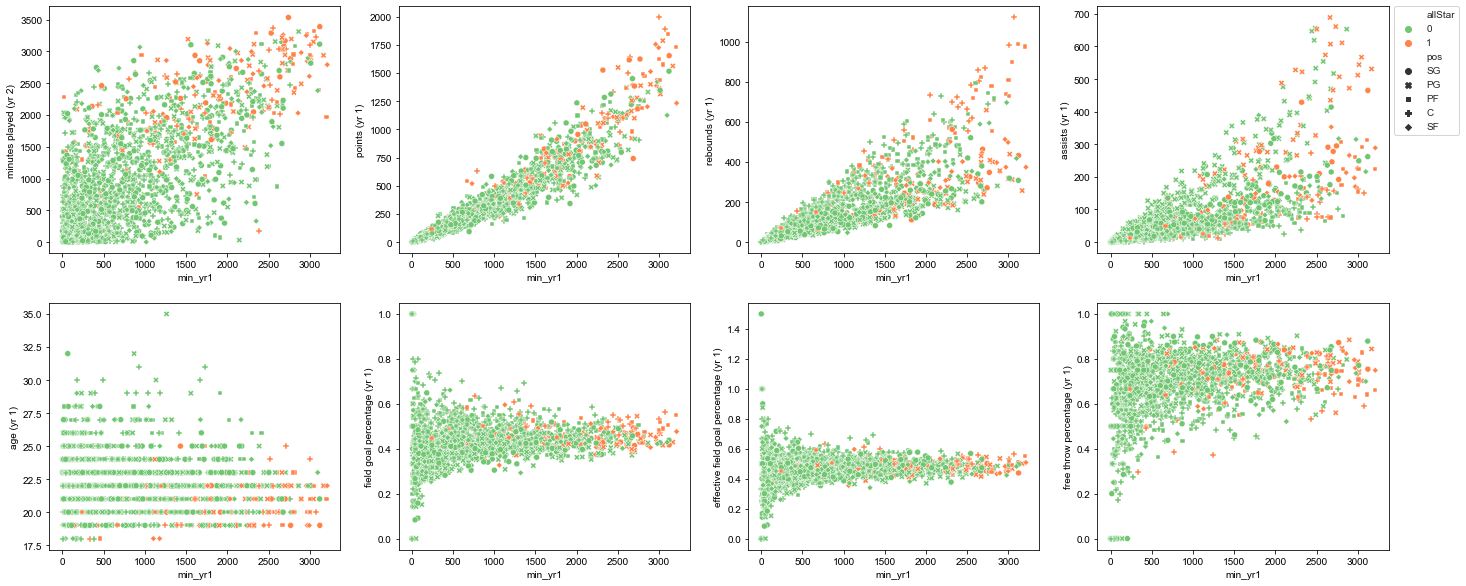

In [7]:
# graphing counting stats against minutes for allstar versus non-allstar
fig, axes = plt.subplots(2, 4, figsize=(24, 10))

sns.scatterplot(ax=axes[0,0], data=stats, x='min_yr1', y='min_yr2', hue='allStar', style="pos", palette=customPalette)
sns.scatterplot(ax=axes[0,1], data=stats, x='min_yr1', y='pts_yr1', hue='allStar', style="pos", palette=customPalette)
sns.scatterplot(ax=axes[0,2], data=stats, x='min_yr1', y='treb_yr1', hue='allStar', style="pos", palette=customPalette)
sns.scatterplot(ax=axes[0,3], data=stats, x='min_yr1', y='ast_yr1', hue='allStar', style="pos", palette=customPalette)
sns.scatterplot(ax=axes[1,0], data=stats, x='min_yr1', y='age_yr1', hue='allStar', style="pos", palette=customPalette)
sns.scatterplot(ax=axes[1,1], data=stats, x='min_yr1', y='fgp_yr1', hue='allStar', style="pos", palette=customPalette)
sns.scatterplot(ax=axes[1,2], data=stats, x='min_yr1', y='efgp_yr1', hue='allStar', style="pos", palette=customPalette)
sns.scatterplot(ax=axes[1,3], data=stats, x='min_yr1', y='ftp_yr1', hue='allStar', style="pos", palette=customPalette)
axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[0,2].get_legend().remove()
axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()
axes[1,2].get_legend().remove()
axes[1,3].get_legend().remove()
axes[0,0].set_ylabel('minutes played (yr 2)')
axes[0,1].set_ylabel('points (yr 1)')
axes[0,2].set_ylabel('rebounds (yr 1)')
axes[0,3].set_ylabel('assists (yr 1)')
axes[1,0].set_ylabel('age (yr 1)')
axes[1,1].set_ylabel('field goal percentage (yr 1)')
axes[1,2].set_ylabel('effective field goal percentage (yr 1)')
axes[1,3].set_ylabel('free throw percentage (yr 1)')
sns.set_style("whitegrid")
axes[0,3].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.show()

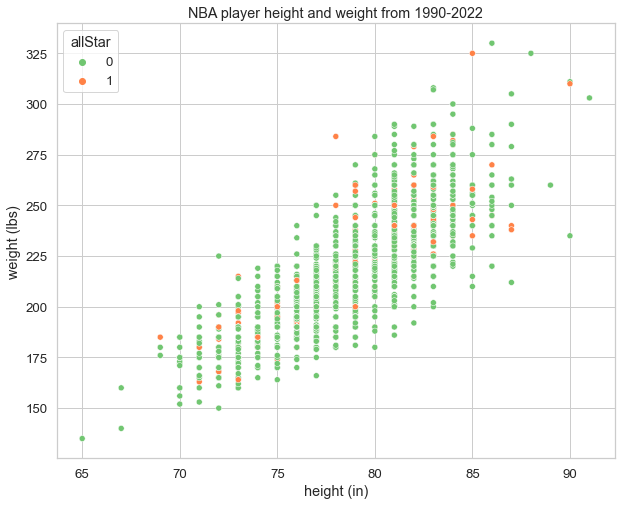

In [8]:
# graphing height and weight to visualize all star achetype
sns.set(font_scale = 1.2)
sns.set_style('whitegrid')
sns.scatterplot(data=stats, x='height', y='weight', hue='allStar', palette = customPalette)
plt.title('NBA player height and weight from 1990-2022')
plt.xlabel('height (in)')
plt.ylabel('weight (lbs)')
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

# players[players['name'] == 'Kevin Durant']

In [9]:
# Shape of the data
allStarIndices = stats_model['allStar'] == 1
allStarDf = stats_model.loc[allStarIndices]
print("Shape of the Data")
print(stats_model.shape)
print(allStarIndices.shape)

# Tallest versus Shortest All-Stars
# shortestAllStar = allStarDf.loc[allStarDf['height'].idxmin()]
# tallestAllStar = allStarDf.loc[allStarDf['height'].idxmax()]
# print(shortestAllStar)
# print(tallestAllStar)

Shape of the Data
(1852, 61)
(1852,)


# Classifiers using sklearn

### Correlation Heatmap 
- Find which stats are correlated to reduce dimensionality of stats later

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


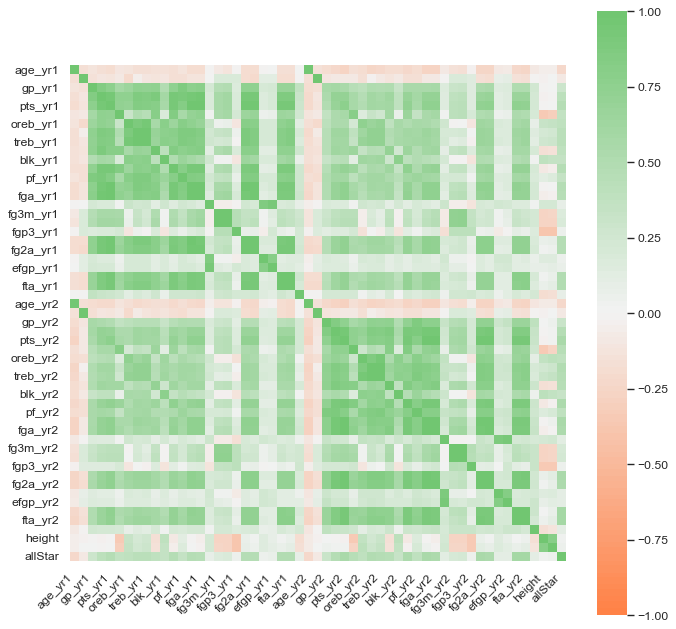

In [10]:
corr = stats.corr()
fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
sns.set(font_scale=1)
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=blendPalette,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Split Data into Training and Testing

In [11]:
X = stats_model.iloc[:,2:-1]
y = stats_model.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

print("Counting Stat Features\n", X.columns.values)

Counting Stat Features
 ['age_yr1' 'season_yr1' 'gp_yr1' 'min_yr1' 'pts_yr1' 'ast_yr1' 'oreb_yr1'
 'dreb_yr1' 'treb_yr1' 'stl_yr1' 'blk_yr1' 'tov_yr1' 'pf_yr1' 'fgm_yr1'
 'fga_yr1' 'fgp_yr1' 'fg3m_yr1' 'fg3a_yr1' 'fgp3_yr1' 'fg2m_yr1'
 'fg2a_yr1' 'fgp2_yr1' 'efgp_yr1' 'ftm_yr1' 'fta_yr1' 'ftp_yr1' 'age_yr2'
 'gp_yr2' 'min_yr2' 'pts_yr2' 'ast_yr2' 'oreb_yr2' 'dreb_yr2' 'treb_yr2'
 'stl_yr2' 'blk_yr2' 'tov_yr2' 'pf_yr2' 'fgm_yr2' 'fga_yr2' 'fgp_yr2'
 'fg3m_yr2' 'fg3a_yr2' 'fgp3_yr2' 'fg2m_yr2' 'fg2a_yr2' 'fgp2_yr2'
 'efgp_yr2' 'ftm_yr2' 'fta_yr2' 'ftp_yr2' 'height' 'weight' 'pos_C'
 'pos_PF' 'pos_PG' 'pos_SF' 'pos_SG']


### Removing highly correlated features
- Saves time on computation and helps with weight imbalance for certain players

In [12]:
corrX = X_train.corr()

columns = np.full((corrX.shape[0],), True, dtype=bool)
for i in range(corrX.shape[0]):
    for j in range(i+1, corrX.shape[0]):
        if corrX.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = X_train.columns[columns]
X_train_reduced = X_train[selected_columns]
X_test_reduced = X_test[selected_columns]

### Use of Smote
- SMOTE is an oversampling technique if there is a lot of imbalances.
- It helps to balance out the confusion matrix because we have many more non-allstars than all-stars

In [13]:
# summarize class distribution
counter = Counter(y_train)
print("X_training shape:", counter)

# over sample the data
oversample = SMOTE(sampling_strategy = 1, random_state = 1234, k_neighbors = 5)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train_smote)
print("Y_training shape:", counter)

X_training shape: Counter({0: 1337, 1: 144})
Y_training shape: Counter({0: 1337, 1: 1337})


## K-Nearest Neighbors

### Model 1A: KNN Classifier on Non-PCA and Non-Smote Data
- Simplest model used

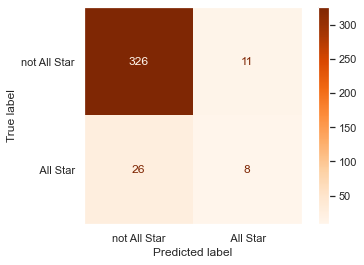

ACCURACY OF THE MODEL:  0.9002695417789758
SENSITIVITY OF THE MODEL:  0.23529411764705882
PRECISION OF THE MODEL:  0.42105263157894735
F1 SCORE:  0.3018867924528302


In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# use the KNN classifier to fit data:
clf_nonpca = KNeighborsClassifier(n_neighbors=1)
clf_nonpca.fit(X_train, y_train)

# predict y data with classifier:
y_predict = clf_nonpca.predict(X_test)
cm = confusion_matrix(y_test, y_predict)

# plot the confusion matrix
classes = ['not All Star', ' All Star']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Oranges')
plt.grid(False)
plt.show()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_predict))
print("SENSITIVITY OF THE MODEL: ", metrics.recall_score(y_test, y_predict))
print("PRECISION OF THE MODEL: ", metrics.precision_score(y_test, y_predict))
print("F1 SCORE: ", metrics.f1_score(y_test, y_predict))

## Model 1B: KNN Classifier on PCA

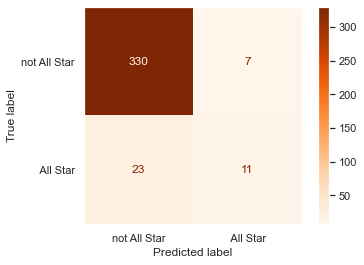

ACCURACY OF THE MODEL:  0.9191374663072777
SENSITIVITY OF THE MODEL:  0.3235294117647059
PRECISION OF THE MODEL:  0.6111111111111112
F1 SCORE:  0.42307692307692313


In [15]:
# scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# obtain principal components
pca = PCA(n_components=10)
pca.fit(X_train_scaled)
Xtrain_pca = pca.transform(X_train_scaled)
Xtest_pca = pca.transform(X_test_scaled)

# use the KNN classifier to fit data:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

# predict y data with classifier:
y_predict = clf.predict(X_test)
cm = confusion_matrix(y_test, y_predict)

# plot the confusion matrix
classes = ['not All Star', ' All Star']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Oranges')
plt.grid(False)
plt.show()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_predict))
print("SENSITIVITY OF THE MODEL: ", metrics.recall_score(y_test, y_predict))
print("PRECISION OF THE MODEL: ", metrics.precision_score(y_test, y_predict))
print("F1 SCORE: ", metrics.f1_score(y_test, y_predict))

### Visualization to compare the results of different numbers of principal components used
- Difficult to see how many principal components works best
- Wanted to un-blackbox parts of the code to see where dimension reduction begins to become effective

X does not have valid feature names, but StandardScaler was fitted with feature names
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


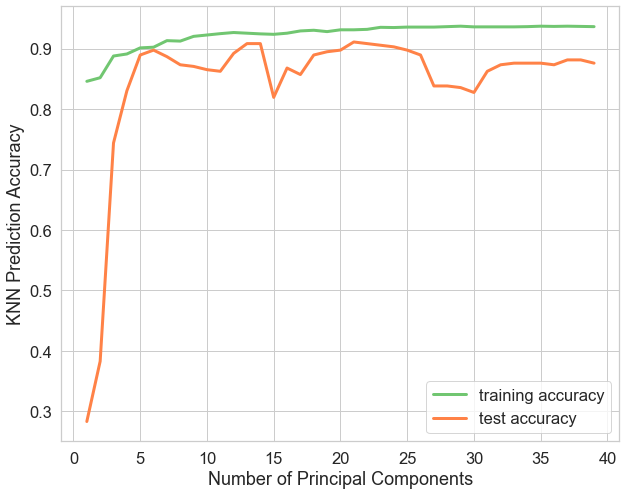

Number of principal components that gives max test accuracy -- 21
Number of principal components that gives max test sensitivity -- 1


In [16]:
# standardize data
scaler = StandardScaler()
scaler.fit(X_train_smote)

X_train_scaled_smote = scaler.transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# separating out the target
y = stats_model.loc[:,['allStar']].values

# KNN parameters
params = {
    "n_neighbors": 20,
    "weights": "uniform",
    "algorithm": "auto",
    "p": 2,
}
classes = ['not All Star', ' All Star']
classifiers = {}
Xtrain_pca = {}
Xtest_pca = {}
y_pred_test = {}
y_pred_train = {}

# empty arrays to be filled
train_accuracy = np.array([])
test_accuracy = np.array([])
train_sensitivity = np.array([])
test_sensitivity = np.array([])
train_precision = np.array([])
test_precision = np.array([])
pca_components = np.arange(1,40)

for i in pca_components:
    # obtain principal components
    pca = PCA(n_components=i)
    pca.fit(X_train_scaled_smote)
    Xtrain_pca[i] = pca.transform(X_train_scaled_smote)
    Xtest_pca[i] = pca.transform(X_test_scaled)

    # explained variance
    pca.explained_variance_ratio_

    # use the KNN classifier to fit data:
    classifiers[i] = KNeighborsClassifier(**params)
    classifiers[i].fit(Xtrain_pca[i], y_train_smote)

    # predict y data with classifier:
    y_pred_test[i] = classifiers[i].predict(Xtest_pca[i])
    y_pred_train[i] = classifiers[i].predict(Xtrain_pca[i])

    # print results:
    cm = confusion_matrix(y_test, y_pred_test[i])
    cm_train = confusion_matrix(y_train_smote, y_pred_train[i])
    test_sensitivity = np.append(test_sensitivity,cm[1][1]/(cm[1][0]+cm[1][1]))
    train_sensitivity = np.append(train_sensitivity,cm_train[1][1]/(cm_train[1][0]+cm_train[1][1]))

    train_accuracy = np.append(train_accuracy, metrics.accuracy_score(y_train_smote, y_pred_train[i]))
    test_accuracy = np.append(test_accuracy, metrics.accuracy_score(y_test, y_pred_test[i]))

    train_precision = np.append(train_precision, metrics.precision_score(y_train_smote, y_pred_train[i]))
    test_precision = np.append(test_precision, metrics.precision_score(y_test, y_pred_test[i]))

# plot result
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')

sns.lineplot(x=pca_components, y=train_accuracy, color='#71C671', linewidth=3)
sns.lineplot(x=pca_components, y=test_accuracy, color='#FF8247', linewidth=3)
plt.legend(labels=['training accuracy','test accuracy'])
plt.xlabel('Number of Principal Components')
plt.ylabel('KNN Prediction Accuracy')
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

# getting the best accuracy and sensitivity for a given PCA
idx_best_accuracy = np.argmax(test_accuracy)
best_pca = pca_components[idx_best_accuracy]
print('Number of principal components that gives max test accuracy -- ' + str(best_pca))

idx_best_sens = np.argmax(test_sensitivity)
best_pca_sens = pca_components[idx_best_sens]
print('Number of principal components that gives max test sensitivity -- ' + str(best_pca_sens))

In [17]:
# rescaling the data for later processes
scaler = StandardScaler()
scaler.fit(X_train_smote)
X_train_scaled_smote = scaler.transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# obtain principal components
pca = PCA(n_components=10)
pca.fit(X_train_scaled_smote)
Xtrain_pca = pca.transform(X_train_scaled_smote)
Xtest_pca = pca.transform(X_test_scaled)

X does not have valid feature names, but StandardScaler was fitted with feature names


## Model 2: Multi-Layer Perceptron Classifier

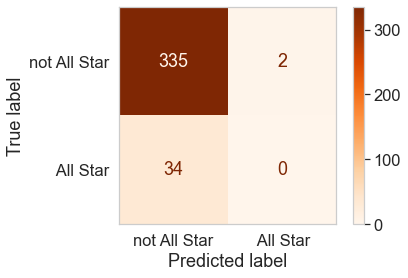

ACCURACY OF THE MODEL:  0.9029649595687331
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.497


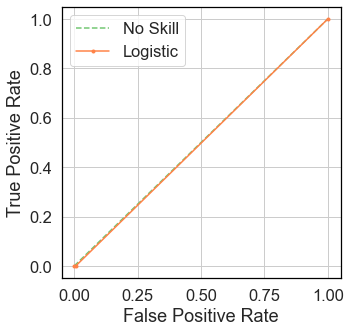

In [18]:
# Create the neural network model here
# TODO: Adjust the hyperparameters here
clf = MLPClassifier(solver='adam', learning_rate='adaptive', alpha=0.0001, hidden_layer_sizes=(10),
                    max_iter = 10000, activation='relu', random_state=1)

# Make predictions
clf.fit(Xtrain_pca, y_train_smote)
y_predict = clf.predict(Xtest_pca)
MLP_results = clf.predict(Xtrain_pca)
MLP_test = clf.predict(Xtest_pca)

# Print results:
cm = confusion_matrix(y_test, y_predict)

# Plot the confusion matrix
classes = ['not All Star', ' All Star']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Oranges')
plt.grid(False)
plt.show()

# Plot the accuracy metrics
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_predict))

# ROC plot
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, MLP_test)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, MLP_test)

# plot the roc curve for the model
fig, ax = plt.subplots(figsize=(5,5))
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
ax.set_facecolor("white")

plt.plot(ns_fpr, ns_tpr, linestyle='--', color='#71C671', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', color = '#FF8247', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()


### Loss Curve
- Sanity check to see if there are any overfitting being done

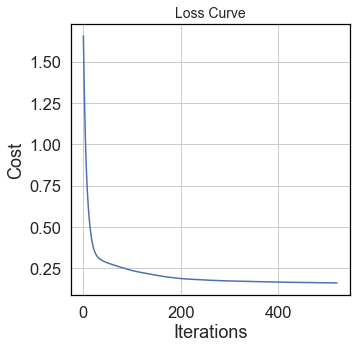

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
ax.set_facecolor("white")
plt.plot(clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

### Visualization of weights
- using shap library to see how the neural network values certain stats
- trying to remove the black-box around the model
    - makes sure there is no bias in the code

In [20]:
# declare the SHAP model
mlp_shap = MLPClassifier(solver='adam', learning_rate='adaptive', alpha=0.0001, hidden_layer_sizes=(35),
                    max_iter = 10000, activation='relu', random_state=1)
mlp_shap.fit(X_train, y_train)
sample = shap.sample(X_test, 50)

# produce the SHAP values
mlp_explainer = shap.KernelExplainer(mlp_shap.predict,sample)
mlp_shap_values = mlp_explainer.shap_values(sample)

  0%|          | 0/50 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


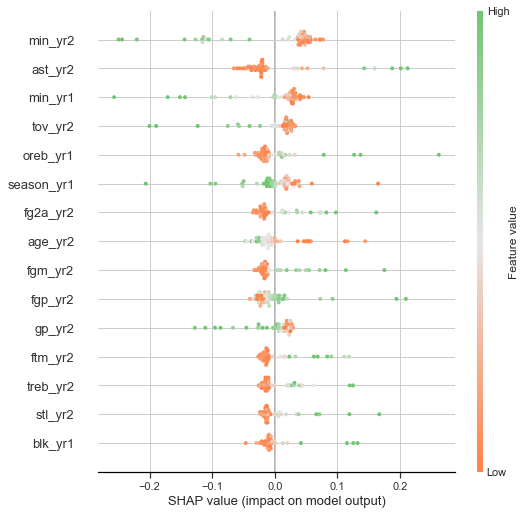

In [22]:
newCmap = LinearSegmentedColormap.from_list("", ['#FF8247','0.9','#71C671'])
feature_names = X.columns.values

# set plot
fig, ax = plt.subplots(figsize=(5,5))
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
ax.set_facecolor("white")
shap.summary_plot(mlp_shap_values, sample, max_display=15,cmap=newCmap, feature_names=feature_names)